# Cab Fare Prediction


#### Problem Statement​ -
You are a cab rental start-up company. You have successfully run the pilot project and now want to launch your cab service across the country. You have collected thehistorical data from your pilot project and now have a requirement to apply analytics forfare prediction. You need to design a system that predicts the fare amount for a cab ride in the city.

In [1]:
# loading the required libraries 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from fancyimpute import KNN
import warnings
warnings.filterwarnings('ignore')
from geopy.distance import geodesic
from geopy.distance import great_circle
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.externals import joblib 

Using TensorFlow backend.


In [2]:
# set the working directory
# os.chdir('C:/Users/admin/Documents/Python Files')
# os.getcwd()

The details of data attributes in the dataset are as follows:
-  pickup_datetime - timestamp value indicating when the cab ride started.
-  pickup_longitude - float for longitude coordinate of where the cab ride started.
-  pickup_latitude - float for latitude coordinate of where the cab ride started.
-  dropoff_longitude - float for longitude coordinate of where the cab ride ended.
-  dropoff_latitude - float for latitude coordinate of where the cab ride ended.
-  passenger_count - an integer indicating the number of passengers in the cab ride.

predictive modeling machine learning project can be broken down into below workflow: 
1. Prepare Problem 
a) Load libraries b) Load dataset 
2. Summarize Data a) Descriptive statistics b) Data visualizations 
3. Prepare Data a) Data Cleaning b) Feature Selection c) Data Transforms 
4. Evaluate Algorithms a) Split-out validation dataset b) Test options and evaluation metric c) Spot Check Algorithms d) Compare Algorithms 
5. Improve Accuracy a) Algorithm Tuning b) Ensembles 
6. Finalize Model a) Predictions on validation dataset b) Create standalone model on entire training dataset c) Save model for later use

In [3]:
# Importing data
train = pd.read_csv('https://s3-ap-southeast-1.amazonaws.com/edwisor-india-bucket/projects/data/DataN0104/train_cab.zip', compression = 'zip', 
                    dtype={'fare_amount':np.float64},na_values={'fare_amount':'430-'})
test = pd.read_csv('https://s3-ap-southeast-1.amazonaws.com/edwisor-india-bucket/projects/data/DataN0104/test.zip', compression = 'zip')
data=[train,test]
for i in data:
    i['pickup_datetime']  = pd.to_datetime(i['pickup_datetime'],errors='coerce')
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16066 non-null datetime64[ns, UTC]
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 878.8 KB


In [5]:
test.head(5)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null datetime64[ns, UTC]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 464.8 KB


In [7]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16066 non-null datetime64[ns, UTC]
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 878.8 KB


In [9]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


## EDA 

-  we will convert passenger_count into a categorical variable because passenger_count is not a continuous variable.
-  passenger_count cannot take continous values. and also they are limited in number if its a cab.

In [10]:
cat_var=['passenger_count']
num_var=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

## Graphical EDA - Data Visualization 

In [11]:
# setting up the sns for plots
sns.set(style='darkgrid',palette='Set1')

Some histogram plots from seaborn library

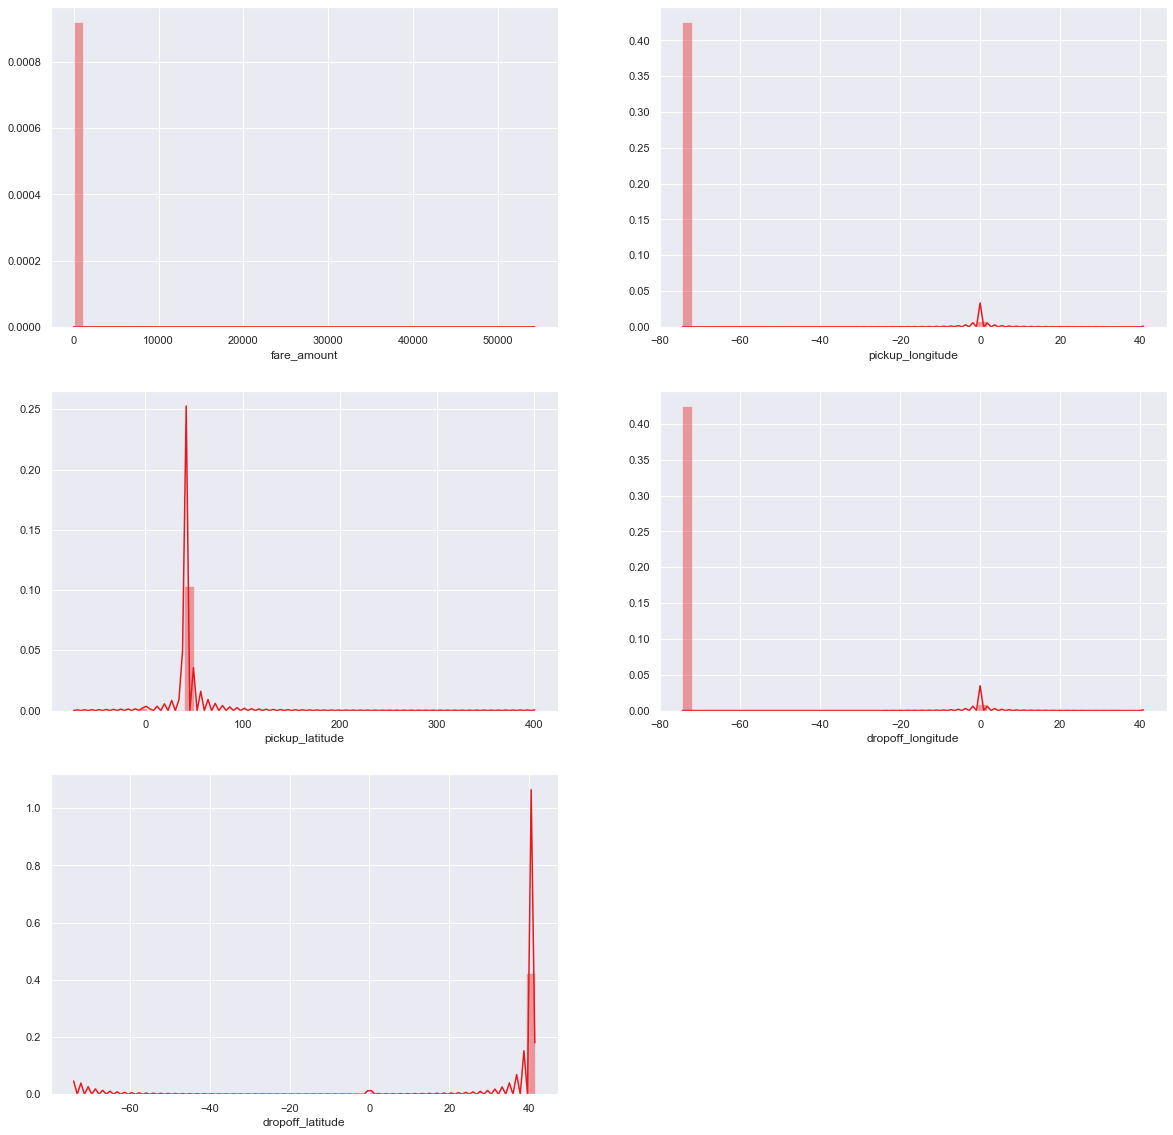

In [12]:
plt.figure(figsize=(20,20))
plt.subplot(321)
_ = sns.distplot(train['fare_amount'],bins=50)
plt.subplot(322)
_ = sns.distplot(train['pickup_longitude'],bins=50)
plt.subplot(323)
_ = sns.distplot(train['pickup_latitude'],bins=50)
plt.subplot(324)
_ = sns.distplot(train['dropoff_longitude'],bins=50)
plt.subplot(325)
_ = sns.distplot(train['dropoff_latitude'],bins=50)
# plt.savefig('hist.png')
plt.show()

Some Bee Swarmplots

In [13]:
# plt.figure(figsize=(25,25))
# _ = sns.swarmplot(x='passenger_count',y='fare_amount',data=train)
# plt.title('Cab Fare w.r.t passenger_count')

-  Jointplots for Bivariate Analysis.
-  Here Scatter plot has regression line between 2 variables along with separate Bar plots of both variables.
-  Also its annotated with pearson correlation coefficient and p value.

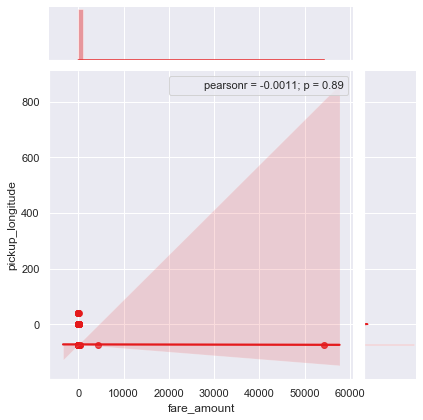

In [14]:
_ = sns.jointplot(x='fare_amount',y='pickup_longitude',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointfplo.png')
plt.show()

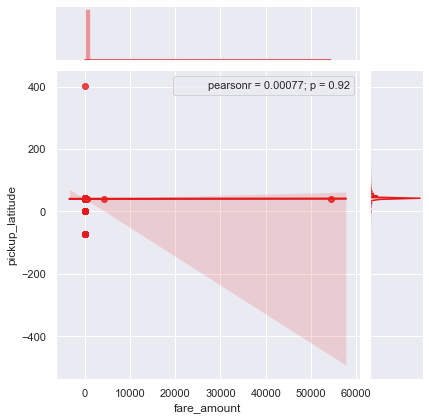

In [15]:
_ = sns.jointplot(x='fare_amount',y='pickup_latitude',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointfpla.png')
plt.show()

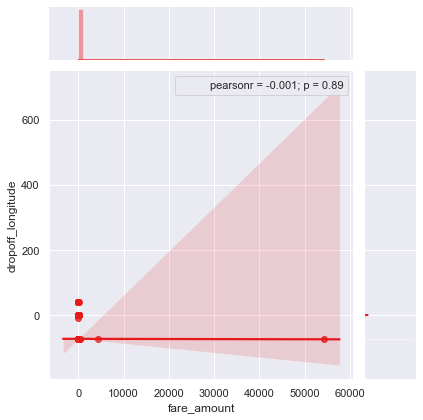

In [16]:
_ = sns.jointplot(x='fare_amount',y='dropoff_longitude',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointfdlo.png')
plt.show()

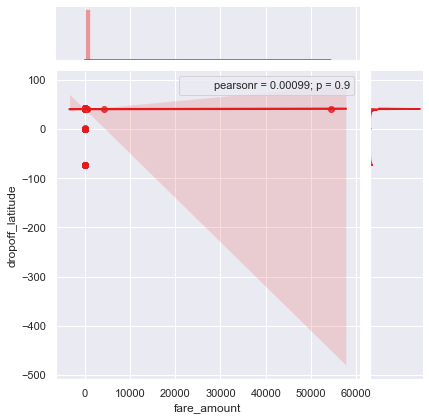

In [17]:
_ = sns.jointplot(x='fare_amount',y='dropoff_latitude',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointfdla.png')
plt.show()

Some Violinplots to see spread of variables

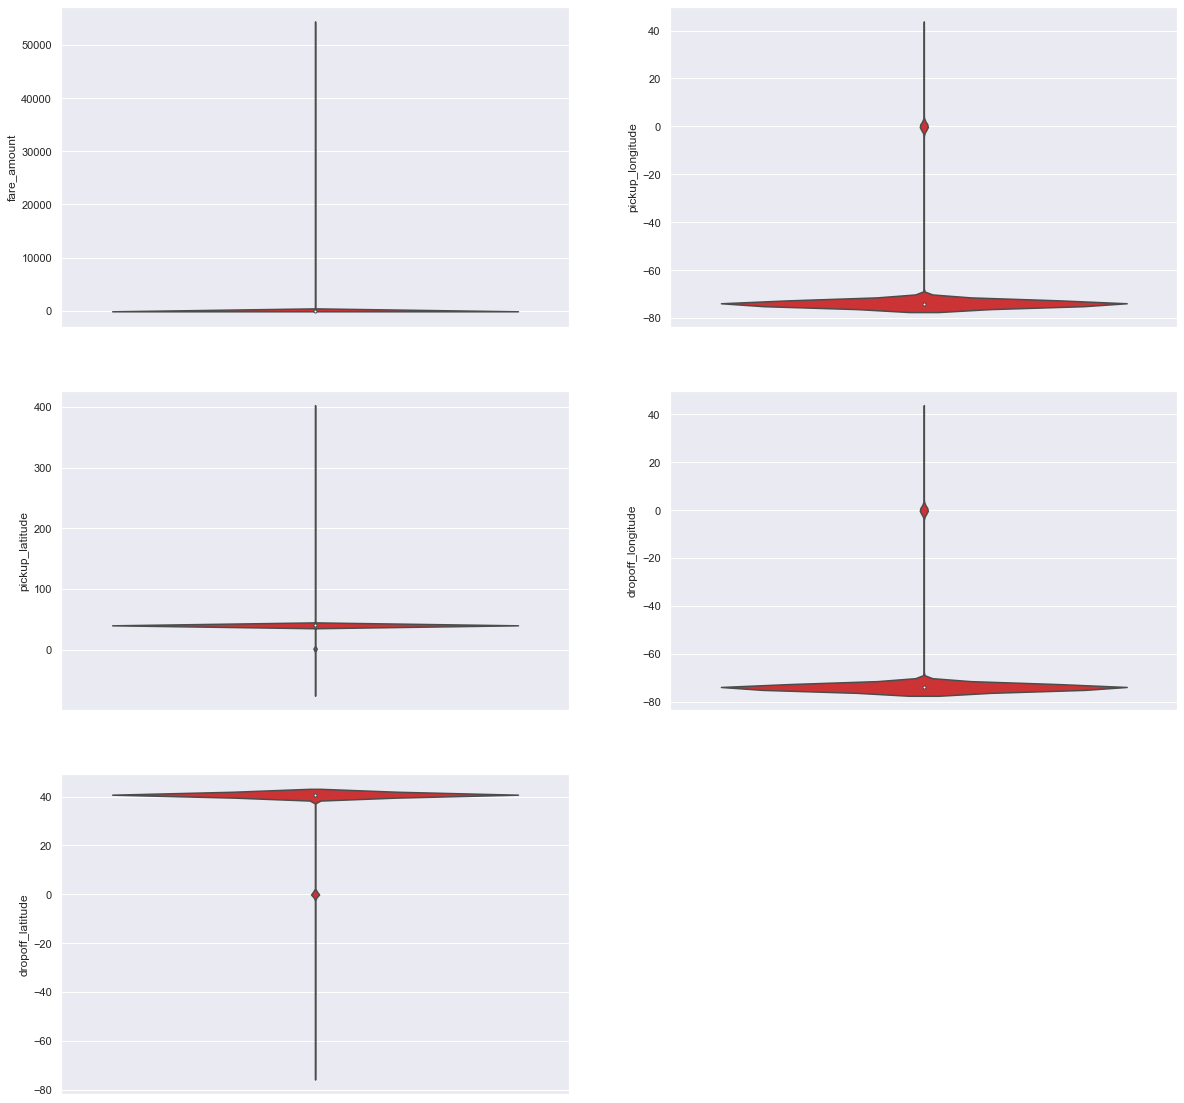

In [18]:
plt.figure(figsize=(20,20))
plt.subplot(321)
_ = sns.violinplot(y='fare_amount',data=train)
plt.subplot(322)
_ = sns.violinplot(y='pickup_longitude',data=train)
plt.subplot(323)
_ = sns.violinplot(y='pickup_latitude',data=train)
plt.subplot(324)
_ = sns.violinplot(y='dropoff_longitude',data=train)
plt.subplot(325)
_ = sns.violinplot(y='dropoff_latitude',data=train)
plt.savefig('violin.png')
plt.show()

Pairplot for all numerical variables

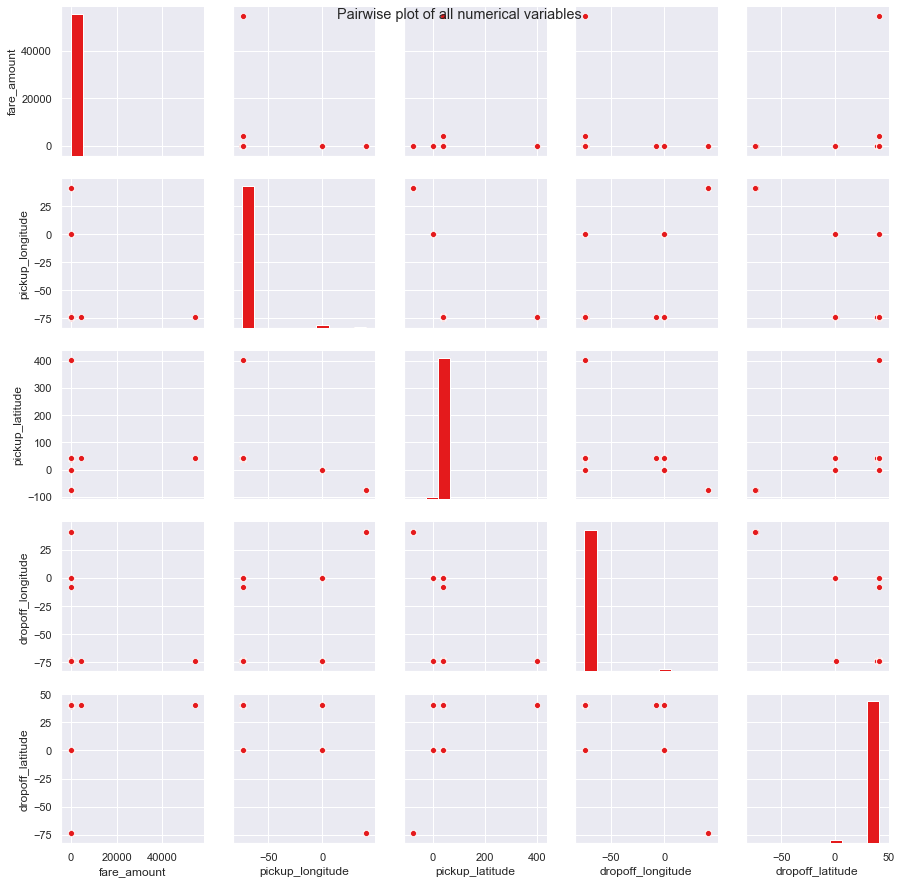

In [19]:
_ =sns.pairplot(data=train[num_var],kind='scatter',dropna=True)
_.fig.suptitle('Pairwise plot of all numerical variables')
# plt.savefig('Pairwise.png')
plt.show()

## Removing values which are not within desired range(outlier) depending upon basic understanding of dataset.

1.Fare amount has a negative value, which doesn't make sense. A price amount cannot be -ve and also cannot be 0. So we will remove these fields.

In [20]:
sum(train['fare_amount']<1)

5

In [21]:
train[train['fare_amount']<1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,-2.90,2010-03-09 23:37:10+00:00,-73.789450,40.643498,-73.788665,40.641952,1.0
2486,-2.50,2015-03-22 05:14:27+00:00,-74.000031,40.720631,-73.999809,40.720539,1.0
2780,0.01,2015-05-01 15:38:41+00:00,-73.939041,40.713963,-73.941673,40.713997,1.0
10002,0.00,2010-02-15 14:26:01+00:00,-73.987115,40.738808,-74.005911,40.713960,1.0
13032,-3.00,2013-08-30 08:57:10+00:00,-73.995062,40.740755,-73.995885,40.741357,4.0


In [22]:
train = train.drop(train[train['fare_amount']<1].index, axis=0)

In [23]:
# train.loc[train['fare_amount'] < 1,'fare_amount'] = np.nan

2.Passenger_count variable

In [24]:
for i in range(4,11):
    print('passenger_count above' +str(i)+'={}'.format(sum(train['passenger_count']>i)))

passenger_count above4=1367
passenger_count above5=322
passenger_count above6=20
passenger_count above7=20
passenger_count above8=20
passenger_count above9=20
passenger_count above10=20


so 20 observations of passenger_count is consistenly above from 6,7,8,9,10 passenger_counts, let's check them.

In [25]:
train[train['passenger_count']>6]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
233,8.5,2011-07-24 01:14:35+00:00,0.000000,0.000000,0.000000,0.000000,236.0
263,4.9,2010-07-12 09:44:33+00:00,-73.983249,40.734655,-73.991278,40.738918,456.0
293,6.1,2011-01-18 23:48:00+00:00,-74.006642,40.738927,-74.010828,40.717907,5334.0
356,8.5,2013-06-18 10:27:05+00:00,-73.992108,40.764203,-73.973000,40.762695,535.0
386,8.1,2009-08-21 19:35:05+00:00,-73.960853,40.761557,-73.976335,40.748361,354.0
413,NaN,2013-09-12 11:32:00+00:00,-73.982060,40.772705,-73.956213,40.771777,55.0
971,10.1,2010-11-21 01:41:00+00:00,-74.004500,40.742143,-73.994330,40.720412,554.0
1007,3.7,2010-12-14 14:46:00+00:00,-73.969157,40.759000,-73.968763,40.764617,53.0
1043,5.7,2012-08-22 22:08:29+00:00,-73.973573,40.760184,-73.953564,40.767392,35.0
1107,4.9,2009-08-08 21:50:50+00:00,-73.988977,40.721068,-73.982368,40.732064,345.0


Also we need to see if there are any passenger_count<1

In [26]:
train[train['passenger_count']<1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
314,34.0,2015-06-02 23:16:15+00:00,-73.974899,40.751095,-73.908546,40.881878,0.00
566,4.9,2012-01-28 21:33:18+00:00,-73.955322,40.782840,-73.955797,40.773673,0.00
678,6.5,2012-02-27 07:24:20+00:00,-73.983397,40.738183,-73.971395,40.758023,0.00
1160,13.3,2011-05-25 23:58:48+00:00,-73.998360,40.740348,-73.946455,40.777348,0.00
1935,10.1,2011-10-23 11:09:28+00:00,-73.971400,40.795000,-73.967900,40.768600,0.00
2200,8.1,2011-05-23 16:54:19+00:00,-73.988008,40.748303,-74.005185,40.738733,0.00
2425,8.9,2011-11-25 22:47:33+00:00,-73.999900,40.738600,-73.971800,40.746300,0.00
3034,5.7,2011-03-06 12:03:14+00:00,-73.986557,40.745783,-73.994545,40.729995,0.00
3413,7.3,2011-02-28 06:39:16+00:00,-73.973413,40.743708,-73.985220,40.741583,0.00
3481,11.3,2011-11-30 17:23:02+00:00,-73.968100,40.762500,-73.984400,40.760900,0.00


In [27]:
len(train[train['passenger_count']<1])

58

In [28]:
test['passenger_count'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

-  passenger_count variable conatins values which are equal to 0.
-  And test data does not contain passenger_count=0 . So if we feature engineer passenger_count of train dataset then it will create a dummy variable for passenger_count=0 which will be an extra feature compared to test dataset.
-  So, we will remove those 0 values.
-  Also, We will remove 20 observation which are above 6 value because a cab cannot hold these number of passengers.

In [29]:
train = train.drop(train[train['passenger_count']>6].index, axis=0)
train = train.drop(train[train['passenger_count']<1].index, axis=0)

In [30]:
# train.loc[train['passenger_count'] >6,'passenger_count'] = np.nan
# train.loc[train['passenger_count'] >1,'passenger_count'] = np.nan

In [31]:
sum(train['passenger_count']>6)

0

3.Latitudes range from -90 to 90.Longitudes range from -180 to 180.
  Removing which does not satisfy these ranges

In [32]:
print('pickup_longitude above 180={}'.format(sum(train['pickup_longitude']>180)))
print('pickup_longitude below -180={}'.format(sum(train['pickup_longitude']<-180)))
print('pickup_latitude above 90={}'.format(sum(train['pickup_latitude']>90)))
print('pickup_latitude below -90={}'.format(sum(train['pickup_latitude']<-90)))
print('dropoff_longitude above 180={}'.format(sum(train['dropoff_longitude']>180)))
print('dropoff_longitude below -180={}'.format(sum(train['dropoff_longitude']<-180)))
print('dropoff_latitude below -90={}'.format(sum(train['dropoff_latitude']<-90)))
print('dropoff_latitude above 90={}'.format(sum(train['dropoff_latitude']>90)))

pickup_longitude above 180=0
pickup_longitude below -180=0
pickup_latitude above 90=1
pickup_latitude below -90=0
dropoff_longitude above 180=0
dropoff_longitude below -180=0
dropoff_latitude below -90=0
dropoff_latitude above 90=0


-  There's only one outlier which is in variable pickup_latitude.So we will remove it with nan.
-  Also we will see if there are any values equal to 0.

In [33]:
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    print(i,'equal to 0={}'.format(sum(train[i]==0)))

pickup_longitude equal to 0=311
pickup_latitude equal to 0=311
dropoff_longitude equal to 0=312
dropoff_latitude equal to 0=310


there are values which are equal to 0. we will remove them.

In [34]:
train = train.drop(train[train['pickup_latitude']>90].index, axis=0)
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    train = train.drop(train[train[i]==0].index, axis=0)

In [35]:
# for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
#     train.loc[train[i]==0,i] = np.nan
# train.loc[train['pickup_latitude']>90,'pickup_latitude'] = np.nan

In [36]:
train.shape

(15661, 7)

So, we lossed 16067-15661=406 observations because of non-sensical values.

In [37]:
df=train.copy()
# train=df.copy()

## Missing Value Analysis 

In [38]:
#Create dataframe with missing percentage
missing_val = pd.DataFrame(train.isnull().sum())
#Reset index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,fare_amount,22
1,pickup_datetime,1
2,pickup_longitude,0
3,pickup_latitude,0
4,dropoff_longitude,0
5,dropoff_latitude,0
6,passenger_count,55


-  As we can see there are some missing values in the data.
-  Also pickup_datetime variable has 1 missing value. 
-  We will impute missing values for fare_amount,passenger_count variables except pickup_datetime.
-  And we will drop that 1 row which has missing value in pickup_datetime.

In [39]:
#Rename variable
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})
missing_val
#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(train))*100
#descending order
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
missing_val

,Variables,Missing_percentage
0,passenger_count,0.351191
1,fare_amount,0.140476
2,pickup_datetime,0.006385
3,pickup_longitude,0.000000
4,pickup_latitude,0.000000
5,dropoff_longitude,0.000000
6,dropoff_latitude,0.000000


1.For Passenger_count:
-  Actual value = 1
-  Mode = 1
-  KNN = 2

In [40]:
# Choosing a random values to replace it as NA
train['passenger_count'].loc[1000]

1.0

In [41]:
# Replacing 1.0 with NA
train['passenger_count'].loc[1000] = np.nan
train['passenger_count'].loc[1000]

nan

In [42]:
# Impute with mode
train['passenger_count'].fillna(train['passenger_count'].mode()[0]).loc[1000]

1.0

We can't use mode method because data will be more biased towards passenger_count=1

2.For fare_amount: 
-  Actual value = 7.0,
-  Mean = 15.117,
-  Median = 8.5,
-  KNN = 7.369801

In [43]:
# for i in ['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
#     # Choosing a random values to replace it as NA
#     a=train[i].loc[1000]
#     print(i,'at loc-1000:{}'.format(a))
#     # Replacing 1.0 with NA
#     train[i].loc[1000] = np.nan
#     print('Value after replacing with nan:{}'.format(train[i].loc[1000]))
#     # Impute with mean
#     print('Value if imputed with mean:{}'.format(train[i].fillna(train[i].mean()).loc[1000]))
#     # Impute with median
#     print('Value if imputed with median:{}\n'.format(train[i].fillna(train[i].median()).loc[1000]))

In [44]:
# Choosing a random values to replace it as NA
a=train['fare_amount'].loc[1000]
print('fare_amount at loc-1000:{}'.format(a))
# Replacing 1.0 with NA
train['fare_amount'].loc[1000] = np.nan
print('Value after replacing with nan:{}'.format(train['fare_amount'].loc[1000]))
# Impute with mean
print('Value if imputed with mean:{}'.format(train['fare_amount'].fillna(train['fare_amount'].mean()).loc[1000]))
# Impute with median
print('Value if imputed with median:{}'.format(train['fare_amount'].fillna(train['fare_amount'].median()).loc[1000]))

fare_amount at loc-1000:7.0
Value after replacing with nan:nan
Value if imputed with mean:15.118196060877349
Value if imputed with median:8.5


In [45]:
train.std()

fare_amount          435.982171
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.266096
dtype: float64

In [46]:
columns=['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']

we will separate pickup_datetime into a different dataframe and then merge with train in feature engineering step.

In [47]:
pickup_datetime=pd.DataFrame(train['pickup_datetime'])

In [48]:
# Imputing with missing values using KNN
# Use 19 nearest rows which have a feature to fill in each row's missing features
train = pd.DataFrame(KNN(k = 19).fit_transform(train.drop('pickup_datetime',axis=1)),columns=columns, index=train.index)

Imputing row 1/15661 with 0 missing, elapsed time: 35.238
Imputing row 101/15661 with 0 missing, elapsed time: 35.238
Imputing row 201/15661 with 0 missing, elapsed time: 35.247
Imputing row 301/15661 with 0 missing, elapsed time: 35.247
Imputing row 401/15661 with 0 missing, elapsed time: 35.247
Imputing row 501/15661 with 0 missing, elapsed time: 35.247
Imputing row 601/15661 with 0 missing, elapsed time: 35.247
Imputing row 701/15661 with 0 missing, elapsed time: 35.247
Imputing row 801/15661 with 0 missing, elapsed time: 35.247
Imputing row 901/15661 with 0 missing, elapsed time: 35.247
Imputing row 1001/15661 with 0 missing, elapsed time: 35.247
Imputing row 1101/15661 with 0 missing, elapsed time: 35.247
Imputing row 1201/15661 with 0 missing, elapsed time: 35.247
Imputing row 1301/15661 with 0 missing, elapsed time: 35.257
Imputing row 1401/15661 with 0 missing, elapsed time: 35.257
Imputing row 1501/15661 with 0 missing, elapsed time: 35.259
Imputing row 1601/15661 with 0 missi

In [49]:
train.std()

fare_amount          435.661995
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.264138
dtype: float64

In [50]:
train.loc[1000]

fare_amount           7.369801
pickup_longitude    -73.995420
pickup_latitude      40.759662
dropoff_longitude   -73.987607
dropoff_latitude     40.751247
passenger_count       2.544158
Name: 1000, dtype: float64

In [51]:
train['passenger_count'].head()

0    1.0
1    1.0
2    2.0
3    1.0
4    1.0
Name: passenger_count, dtype: float64

In [52]:
train['passenger_count']=train['passenger_count'].astype('int')

In [53]:
train.std()

fare_amount          435.661995
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.264322
dtype: float64

In [54]:
train['passenger_count'].unique()

array([1, 2, 3, 6, 5, 4], dtype=int64)

In [55]:
train['passenger_count']=train['passenger_count'].round().astype('object').astype('category')

In [56]:
train['passenger_count'].unique()

[1, 2, 3, 6, 5, 4]
Categories (6, int64): [1, 2, 3, 6, 5, 4]

In [57]:
train.loc[1000]

fare_amount           7.3698
pickup_longitude    -73.9954
pickup_latitude      40.7597
dropoff_longitude   -73.9876
dropoff_latitude     40.7512
passenger_count            2
Name: 1000, dtype: object

-  Now about missing value in pickup_datetime

In [58]:
pickup_datetime.head()

,pickup_datetime
0,2009-06-15 17:26:21+00:00
1,2010-01-05 16:52:16+00:00
2,2011-08-18 00:35:00+00:00
3,2012-04-21 04:30:42+00:00
4,2010-03-09 07:51:00+00:00


In [59]:
#Create dataframe with missing percentage
missing_val = pd.DataFrame(pickup_datetime.isnull().sum())
#Reset index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,pickup_datetime,1


In [60]:
pickup_datetime.shape

(15661, 1)

In [61]:
train.shape

(15661, 6)

-  We will drop 1 row which has missing value for pickup_datetime variable after feature engineering step because if we drop now, pickup_datetime dataframe will have 16040 rows and our train has 1641 rows, then if we merge these 2 dataframes then pickup_datetime variable will gain 1 missing value.
-  And if we merge and then drop now then we would require to split again before outlier analysis and then merge again in feature engineering step.
-  So, instead of doing the work 2 times we will drop 1 time i.e. after feature engineering process.

In [62]:
train['passenger_count'].describe()

count     15661
unique        6
top           1
freq      11056
Name: passenger_count, dtype: int64

In [63]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,15.110669,-73.911514,40.689712,-73.906315,40.687655
std,435.661995,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.500000,-73.982049,40.753300,-73.980555,40.754242
75%,12.500000,-73.968080,40.767805,-73.965360,40.768312
max,54343.000000,40.766125,41.366138,40.802437,41.366138


## Outlier Analysis using Boxplot
-  We Will do Outlier Analysis only on Fare_amount just for now and we will do outlier analysis after feature engineering laitudes and longitudes.

-  Univariate Boxplots: Boxplots for all Numerical Variables including target variable.

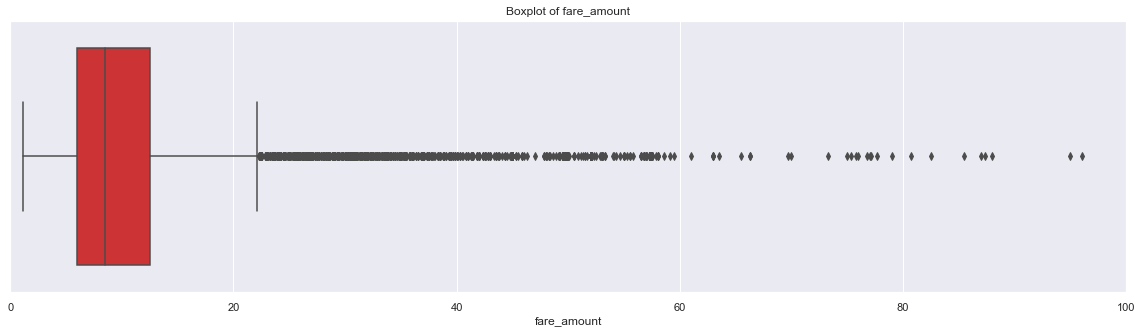

In [64]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=train['fare_amount'],data=train,orient='h')
plt.title('Boxplot of fare_amount')
# plt.savefig('bp of fare_amount.png')
plt.show()

In [65]:
# sum(train['fare_amount']<22.5)/len(train['fare_amount'])*100

-  Bivariate Boxplots: Boxplot for Numerical Variable Vs Categorical Variable.

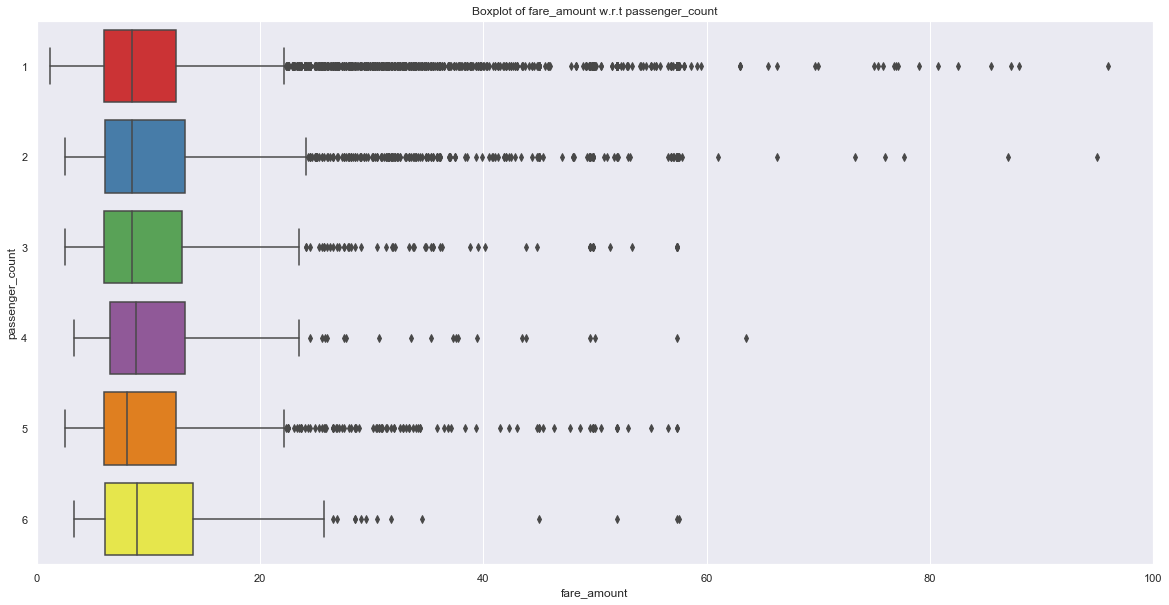

In [66]:
plt.figure(figsize=(20,10))
plt.xlim(0,100)
_ = sns.boxplot(x=train['fare_amount'],y=train['passenger_count'],data=train,orient='h')
plt.title('Boxplot of fare_amount w.r.t passenger_count')
# plt.savefig('Boxplot of fare_amount w.r.t passenger_count.png')
plt.show()

In [67]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,15.110669,-73.911514,40.689712,-73.906315,40.687655
std,435.661995,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.500000,-73.982049,40.753300,-73.980555,40.754242
75%,12.500000,-73.968080,40.767805,-73.965360,40.768312
max,54343.000000,40.766125,41.366138,40.802437,41.366138


In [68]:
train['passenger_count'].describe()

count     15661
unique        6
top           1
freq      11056
Name: passenger_count, dtype: int64

## Outlier Treatment
-  As we can see from the above Boxplots there are outliers in the train dataset.
-  Reconsider pickup_longitude,etc.

In [69]:
def outlier_treatment(col):
    ''' calculating outlier indices and replacing them with NA  '''
    #Extract quartiles
    q75, q25 = np.percentile(train[col], [75 ,25])
    print(q75,q25)
    #Calculate IQR
    iqr = q75 - q25
    #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    print(minimum,maximum)
    #Replace with NA
    train.loc[train[col] < minimum,col] = np.nan
    train.loc[train[col] > maximum,col] = np.nan

In [70]:
# for i in num_var:
outlier_treatment('fare_amount')
#     outlier_treatment('pickup_longitude')
#     outlier_treatment('pickup_latitude')
#     outlier_treatment('dropoff_longitude')
#     outlier_treatment('dropoff_latitude')

12.5 6.0
-3.75 22.25


In [71]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,1359
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [72]:
train.std()

fare_amount          4.136102
pickup_longitude     2.659050
pickup_latitude      2.613305
dropoff_longitude    2.710835
dropoff_latitude     2.632400
passenger_count      1.264322
dtype: float64

In [73]:
#Imputing with missing values using KNN
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns, index=train.index)

Imputing row 1/15661 with 0 missing, elapsed time: 36.032
Imputing row 101/15661 with 0 missing, elapsed time: 36.032
Imputing row 201/15661 with 0 missing, elapsed time: 36.032
Imputing row 301/15661 with 1 missing, elapsed time: 36.032
Imputing row 401/15661 with 0 missing, elapsed time: 36.032
Imputing row 501/15661 with 0 missing, elapsed time: 36.032
Imputing row 601/15661 with 1 missing, elapsed time: 36.032
Imputing row 701/15661 with 0 missing, elapsed time: 36.047
Imputing row 801/15661 with 0 missing, elapsed time: 36.047
Imputing row 901/15661 with 0 missing, elapsed time: 36.047
Imputing row 1001/15661 with 0 missing, elapsed time: 36.047
Imputing row 1101/15661 with 1 missing, elapsed time: 36.047
Imputing row 1201/15661 with 0 missing, elapsed time: 36.047
Imputing row 1301/15661 with 0 missing, elapsed time: 36.047
Imputing row 1401/15661 with 0 missing, elapsed time: 36.047
Imputing row 1501/15661 with 0 missing, elapsed time: 36.047
Imputing row 1601/15661 with 0 missi

In [74]:
train.std()

fare_amount          4.476970
pickup_longitude     2.659050
pickup_latitude      2.613305
dropoff_longitude    2.710835
dropoff_latitude     2.632400
passenger_count      1.264322
dtype: float64

In [75]:
train['passenger_count'].describe()

count    15661.000000
mean         1.649192
std          1.264322
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

In [76]:
train['passenger_count']=train['passenger_count'].astype('int').round().astype('object').astype('category')

In [77]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,9.404603,-73.911514,40.689712,-73.906315,40.687655
std,4.476970,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.200000,-73.982049,40.753300,-73.980555,40.754242
75%,11.800000,-73.968080,40.767805,-73.965360,40.768312
max,22.100000,40.766125,41.366138,40.802437,41.366138


In [78]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [79]:
df2 = train.copy()
# train=df2.copy()

In [80]:
train.shape

(15661, 6)

## Feature Engineering

#### 1.Feature Engineering for timestamp variable
-  we will derive new features from pickup_datetime variable
-  new features will be year,month,day_of_week,hour

In [81]:
# we will Join 2 Dataframes pickup_datetime and train
train = pd.merge(pickup_datetime,train,right_index=True,left_index=True)
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [82]:
train.shape

(15661, 7)

In [83]:
train=train.reset_index(drop=True)

As we discussed in Missing value imputation step about dropping missing value, we will do it now.

In [84]:
pd.DataFrame(train.isna().sum())

,0
pickup_datetime,1
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [85]:
train=train.dropna()

In [86]:
data = [train,test]
for i in data:
    i["year"] = i["pickup_datetime"].apply(lambda row: row.year)
    i["month"] = i["pickup_datetime"].apply(lambda row: row.month)
#     i["day_of_month"] = i["pickup_datetime"].apply(lambda row: row.day)
    i["day_of_week"] = i["pickup_datetime"].apply(lambda row: row.dayofweek)
    i["hour"] = i["pickup_datetime"].apply(lambda row: row.hour)

In [87]:
# train_nodummies=train.copy()
# train=train_nodummies.copy()

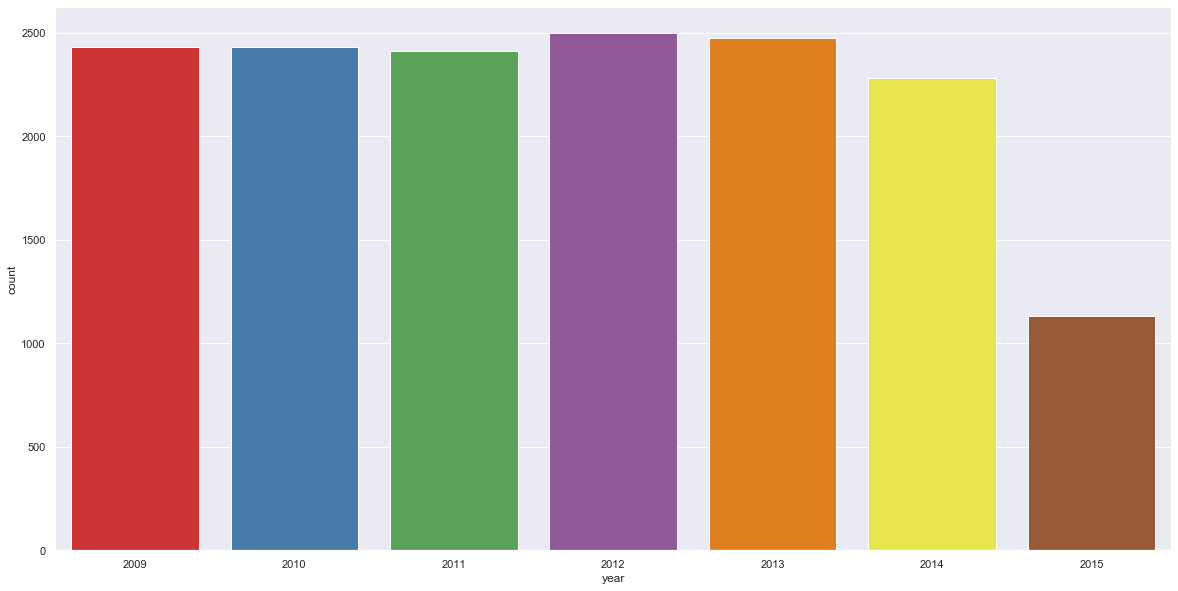

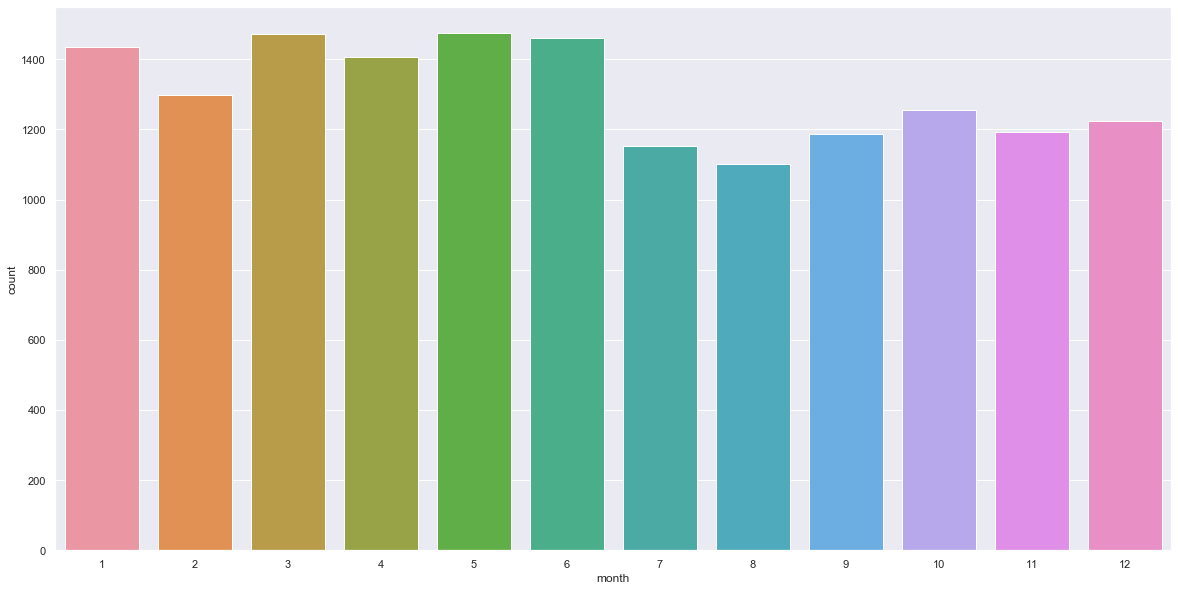

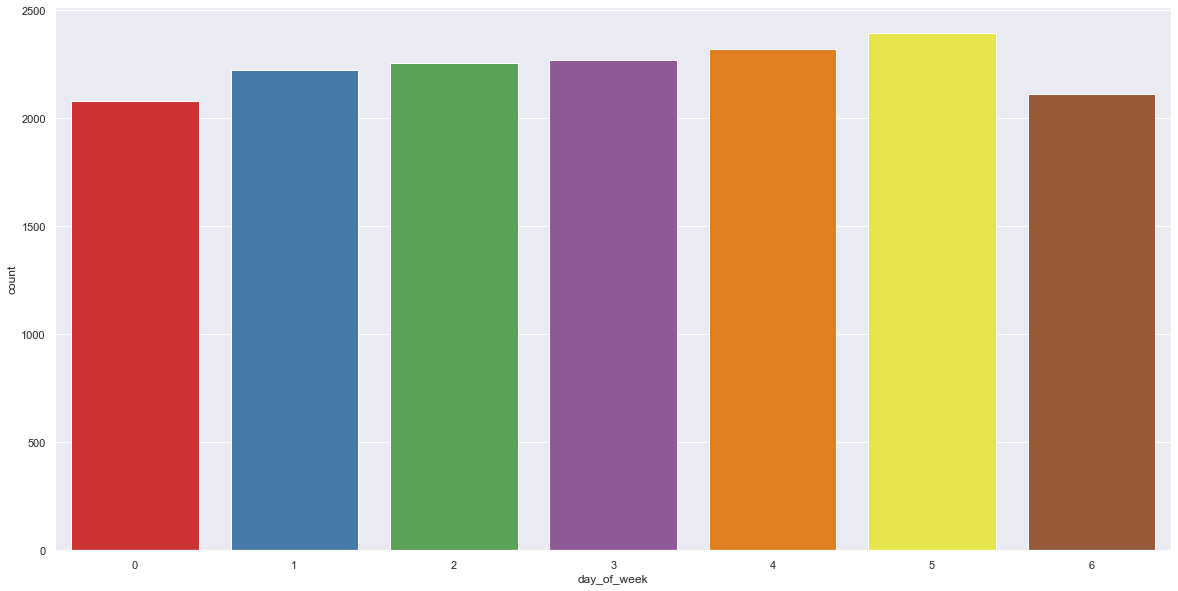

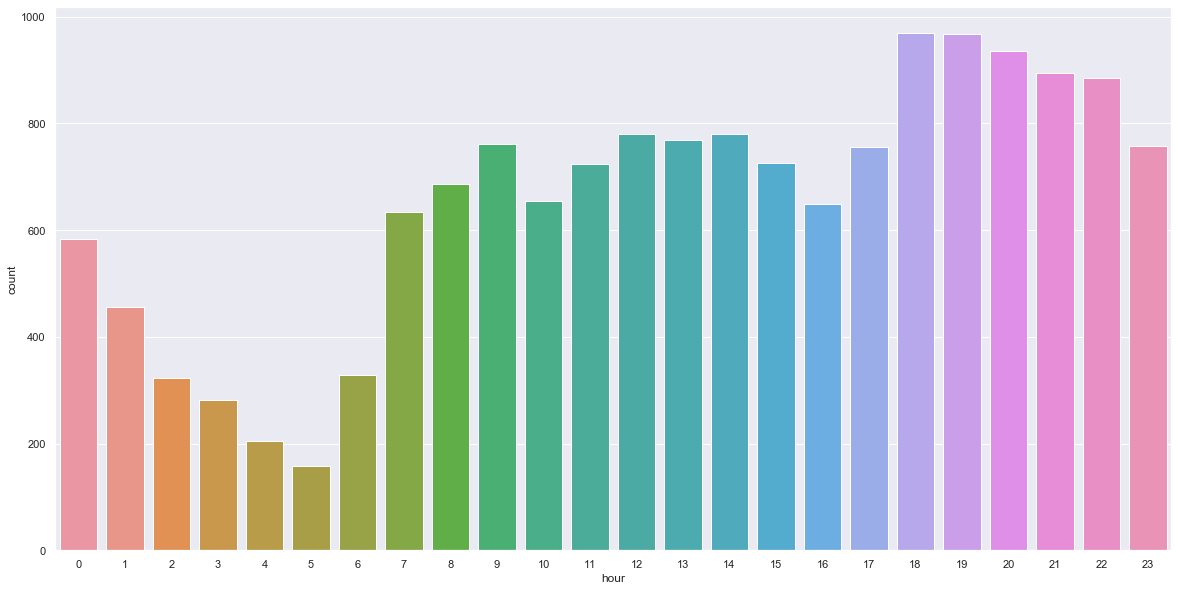

In [88]:
plt.figure(figsize=(20,10))
sns.countplot(train['year'])
# plt.savefig('year.png')

plt.figure(figsize=(20,10))
sns.countplot(train['month'])
# plt.savefig('month.png')

plt.figure(figsize=(20,10))
sns.countplot(train['day_of_week'])
# plt.savefig('day_of_week.png')

plt.figure(figsize=(20,10))
sns.countplot(train['hour'])
# plt.savefig('hour.png')

Now we will use month,day_of_week,hour to derive new features like sessions in a day,seasons in a year,week:weekend/weekday

In [89]:
def f(x):
    ''' for sessions in a day using hour column '''
    if (x >=5) and (x <= 11):
        return 'morning'
    elif (x >=12) and (x <=16 ):
        return 'afternoon'
    elif (x >= 17) and (x <= 20):
        return'evening'
    elif (x >=21) and (x <= 23) :
        return 'night_PM'
    elif (x >=0) and (x <=4):
        return'night_AM'

In [90]:
def g(x):
    ''' for seasons in a year using month column'''
    if (x >=3) and (x <= 5):
        return 'spring'
    elif (x >=6) and (x <=8 ):
        return 'summer'
    elif (x >= 9) and (x <= 11):
        return'fall'
    elif (x >=12)|(x <= 2) :
        return 'winter'

In [91]:
def h(x):
    ''' for week:weekday/weekend in a day_of_week column '''
    if (x >=0) and (x <= 4):
        return 'weekday'
    elif (x >=5) and (x <=6 ):
        return 'weekend'

In [92]:
train['session'] = train['hour'].apply(f)
test['session'] = test['hour'].apply(f)
# train_nodummies['session'] = train_nodummies['hour'].apply(f)

In [93]:
train['seasons'] = train['month'].apply(g)
test['seasons'] = test['month'].apply(g)
# train['seasons'] = test['month'].apply(g)

In [94]:
train['week'] = train['day_of_week'].apply(h)
test['week'] = test['day_of_week'].apply(h)

In [95]:
train.shape

(15660, 14)

In [96]:
test.shape

(9914, 13)

#### 2.Feature Engineering for passenger_count variable
- Because models in scikit learn require numerical input,if dataset contains categorical variables then we have to encode them.
- We will use one hot encoding technique for passenger_count variable.

In [97]:
train['passenger_count'].describe()

count     15660
unique        6
top           1
freq      11055
Name: passenger_count, dtype: int64

In [98]:
#Creating dummies for each variable in passenger_count and merging dummies dataframe to both train and test dataframe
temp = pd.get_dummies(train['passenger_count'], prefix = 'passenger_count')
train = train.join(temp)
temp = pd.get_dummies(test['passenger_count'], prefix = 'passenger_count')
test = test.join(temp)
temp = pd.get_dummies(train['seasons'], prefix = 'season')
train = train.join(temp)
temp = pd.get_dummies(test['seasons'], prefix = 'season')
test = test.join(temp)
temp = pd.get_dummies(train['week'], prefix = 'week')
train = train.join(temp)
temp = pd.get_dummies(test['week'], prefix = 'week')
test = test.join(temp)
temp = pd.get_dummies(train['session'], prefix = 'session')
train = train.join(temp)
temp = pd.get_dummies(test['session'], prefix = 'session')
test = test.join(temp)
temp = pd.get_dummies(train['year'], prefix = 'year')
train = train.join(temp)
temp = pd.get_dummies(test['year'], prefix = 'year')
test = test.join(temp)

In [99]:
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_morning,session_night_AM,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,...,0,0,0,1,0,0,0,0,0,0
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,0,0,1,0,0,0,0,0
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,0,1,0,0,0,1,0,0,0,0
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,0,1,0,0,0,0,1,0,0,0
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,1,0,0,0,1,0,0,0,0,0


In [100]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_morning,session_night_AM,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,1,0,0,0,0,1,0,0,0,0
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0


we will drop one column from each one-hot-encoded variables

In [101]:
train.columns

Index(['pickup_datetime', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'week_weekday', 'week_weekend', 'session_afternoon', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2009',
       'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014',
       'year_2015'],
      dtype='object')

In [102]:
train=train.drop(['passenger_count_1','season_fall','week_weekday','session_afternoon','year_2009'],axis=1)
test=test.drop(['passenger_count_1','season_fall','week_weekday','session_afternoon','year_2009'],axis=1)

#### 3.Feature Engineering for latitude and longitude variable
-  As we have latitude and longitude data for pickup and dropoff, we will find the distance the cab travelled from pickup and dropoff location.

In [103]:
# train.sort_values('pickup_datetime')

In [104]:
# def haversine(coord1, coord2):
#     '''Calculate distance the cab travelled from pickup and dropoff location using the Haversine Formula'''
#     data = [train, test]
#     for i in data:
#         lon1, lat1 = coord1
#         lon2, lat2 = coord2
#         R = 6371000  # radius of Earth in meters
#         phi_1 = np.radians(i[lat1])
#         phi_2 = np.radians(i[lat2])
#         delta_phi = np.radians(i[lat2] - i[lat1])
#         delta_lambda = np.radians(i[lon2] - i[lon1])
#         a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2
#         c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#         meters = R * c  # output distance in meters
#         km = meters / 1000.0  # output distance in kilometers
#         miles = round(km, 3)/1.609344
#         i['distance'] = miles
# #     print(f"Distance: {miles} miles")
# #     return miles

In [105]:
# haversine(['pickup_longitude','pickup_latitude'],['dropoff_longitude','dropoff_latitude'])

In [106]:
# Calculate distance the cab travelled from pickup and dropoff location using great_circle from geopy library
data = [train, test]
for i in data:
    i['great_circle']=i.apply(lambda x: great_circle((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)
    i['geodesic']=i.apply(lambda x: geodesic((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)

In [107]:
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,...,0,0,0,0,0,0,0,0,0.640488,0.639764
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,1,0,0,0,0,0,5.250677,5.246511
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,1,0,0,1,0,0,0,0,0.863412,0.863167
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,1,0,0,0,1,0,0,0,1.739388,1.737223
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,0,0,1,0,0,0,0,0,1.242220,1.241710


In [108]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,1,1.443609,1.442197
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,1,1.507047,1.506080
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,0,0,0,1,0,0,0,0,0.384398,0.384120
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,0,1,0,0,1,0,0,0,1.218531,1.217683
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,0,1,0,0,1,0,0,0,3.347519,3.344737


As Vincenty is more accurate than haversine. Also vincenty is prefered for short distances.Therefore we will drop great_circle. we will drop them together with other variables which were used to feature engineer.

In [109]:
pd.DataFrame(train.isna().sum())

,0
pickup_datetime,0
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
year,0
month,0
day_of_week,0


In [110]:
pd.DataFrame(test.isna().sum())

,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
year,0
month,0
day_of_week,0
hour,0


#### We will remove the variables which were used to feature engineer new variables

In [111]:
# train_nodummies=train_nodummies.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
#        'dropoff_longitude', 'dropoff_latitude','great_circle'],axis = 1)
# test_nodummies=test.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
#        'dropoff_longitude', 'dropoff_latitude','passenger_count_1', 'passenger_count_2', 'passenger_count_3',
#        'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
#        'season_fall', 'season_spring', 'season_summer', 'season_winter',
#        'week_weekday', 'week_weekend', 'session_afternoon', 'session_evening',
#        'session_morning', 'session_night (AM)', 'session_night (PM)',
#        'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
#        'year_2014', 'year_2015', 'great_circle'],axis = 1)

In [112]:
train=train.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week','great_circle'],axis=1)
test=test.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week','great_circle'],axis=1)

In [113]:
train.shape,test.shape

((15660, 21), (9914, 20))

In [114]:
# test_nodummies.columns

In [115]:
# train_nodummies.columns

In [116]:
train.columns

Index(['fare_amount', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_spring', 'season_summer', 'season_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [117]:
test.columns

Index(['passenger_count_2', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'season_spring',
       'season_summer', 'season_winter', 'week_weekend', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'geodesic'],
      dtype='object')

In [118]:
train.head()

,fare_amount,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,season_spring,season_summer,season_winter,week_weekend,...,session_morning,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,4.5,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.639764
1,16.9,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,5.246511
2,5.7,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0.863167
3,7.7,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1.737223
4,5.3,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1.241710


In [119]:
test.head()

,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,season_spring,season_summer,season_winter,week_weekend,session_evening,session_morning,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1.442197
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1.506080
2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0.384120
3,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1.217683
4,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,3.344737


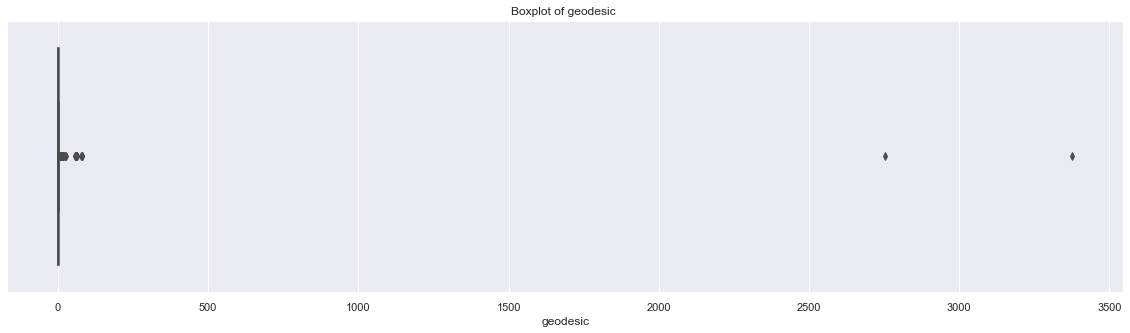

In [120]:
plt.figure(figsize=(20,5)) 
sns.boxplot(x=train['geodesic'],data=train,orient='h')
plt.title('Boxplot of geodesic ')
# plt.savefig('bp geodesic.png')
plt.show()

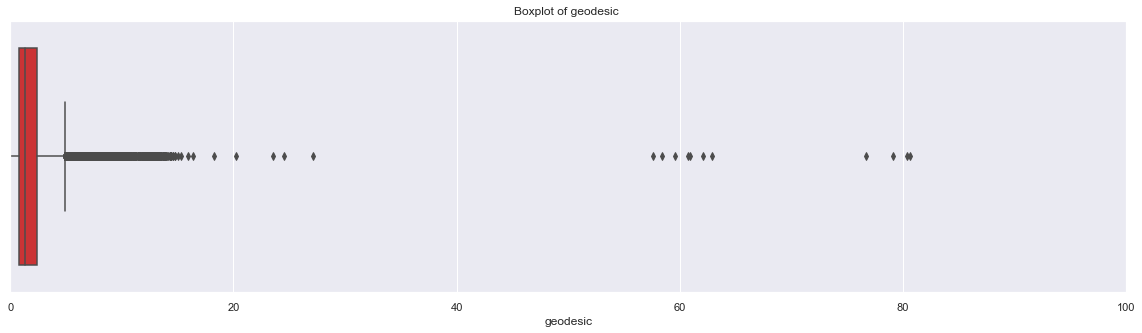

In [121]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=train['geodesic'],data=train,orient='h')
plt.title('Boxplot of geodesic ')
# plt.savefig('bp geodesic.png')
plt.show()

In [122]:
outlier_treatment('geodesic')

2.425668049965582 0.7815214474966259
-1.6846984562068081 4.891887953669016


In [123]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,0
passenger_count_2,0
passenger_count_3,0
passenger_count_4,0
passenger_count_5,0
passenger_count_6,0
season_spring,0
season_summer,0
season_winter,0
week_weekend,0


In [124]:
#Imputing with missing values using KNN
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns, index=train.index)

Imputing row 1/15660 with 0 missing, elapsed time: 56.543
Imputing row 101/15660 with 0 missing, elapsed time: 56.543
Imputing row 201/15660 with 0 missing, elapsed time: 56.543
Imputing row 301/15660 with 1 missing, elapsed time: 56.543
Imputing row 401/15660 with 0 missing, elapsed time: 56.543
Imputing row 501/15660 with 0 missing, elapsed time: 56.543
Imputing row 601/15660 with 1 missing, elapsed time: 56.559
Imputing row 701/15660 with 0 missing, elapsed time: 56.559
Imputing row 801/15660 with 0 missing, elapsed time: 56.559
Imputing row 901/15660 with 0 missing, elapsed time: 56.559
Imputing row 1001/15660 with 0 missing, elapsed time: 56.559
Imputing row 1101/15660 with 1 missing, elapsed time: 56.559
Imputing row 1201/15660 with 0 missing, elapsed time: 56.559
Imputing row 1301/15660 with 0 missing, elapsed time: 56.559
Imputing row 1401/15660 with 0 missing, elapsed time: 56.559
Imputing row 1501/15660 with 0 missing, elapsed time: 56.559
Imputing row 1601/15660 with 0 missi

## Feature Selection
1.Correlation Analysis

    Statistically correlated: features move together directionally.
    Linear models assume feature independence.
    And if features are correlated that could introduce bias into our models.

In [125]:
cat_var=['passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_spring', 'season_summer',
       'season_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015']
num_var=['fare_amount','geodesic']
train[cat_var]=train[cat_var].apply(lambda x: x.astype('category') )
test[cat_var]=test[cat_var].apply(lambda x: x.astype('category') ) 

-  We will plot a Heatmap of correlation whereas, correlation measures how strongly 2 quantities are related to each other.

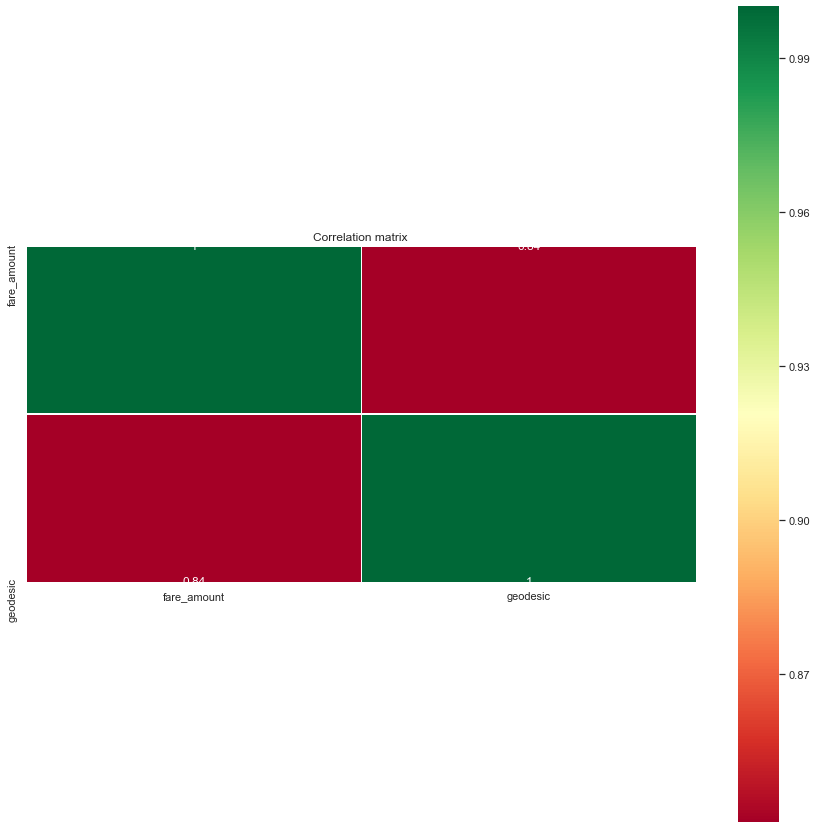

In [126]:
# heatmap using correlation matrix
plt.figure(figsize=(15,15))
_ = sns.heatmap(train[num_var].corr(), square=True, cmap='RdYlGn',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')
# plt.savefig('correlation.png')
plt.show()

As we can see from above correlation plot fare_amount and geodesic is correlated to each other.

-  Jointplots for Bivariate Analysis.
-  Here Scatter plot has regression line between 2 variables along with separate Bar plots of both variables.
-  Also its annotated with pearson correlation coefficient and p value.

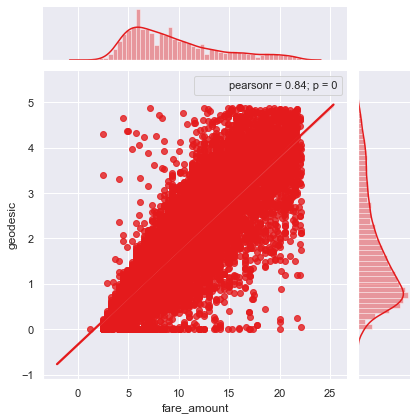

In [127]:
_ = sns.jointplot(x='fare_amount',y='geodesic',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointct.png')
plt.show()

### Chi-square test of Independence for Categorical Variables/Features

-  Hypothesis testing :
    -  Null Hypothesis: 2 variables are independent.
    -  Alternate Hypothesis: 2 variables are not independent.
-  If p-value is less than 0.05 then we reject the null hypothesis saying that 2 variables are dependent.
-  And if p-value is greater than 0.05 then we accept the null hypothesis saying that 2 variables are independent. 
-  There should be no dependencies between Independent variables.
-  So we will remove that variable whose p-value with other variable is low than 0.05.
-  And we will keep that variable whose p-value with other variable is high than 0.05

In [128]:
#loop for chi square values
for i in cat_var:
    for j in cat_var:
        if(i != j):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(train[i], train[j]))
            if(p < 0.05):
                print(i,"and",j,"are dependent on each other with",p,'----Remove')
            else:
                print(i,"and",j,"are independent on each other with",p,'----Keep')

passenger_count_2 and passenger_count_3 are dependent on each other with 1.7121597150859386e-27 ----Remove
passenger_count_2 and passenger_count_4 are dependent on each other with 1.158785630549477e-13 ----Remove
passenger_count_2 and passenger_count_5 are dependent on each other with 1.02944814727332e-42 ----Remove
passenger_count_2 and passenger_count_6 are dependent on each other with 1.0340832329142975e-12 ----Remove
passenger_count_2 and season_spring are independent on each other with 0.983869902597337 ----Keep
passenger_count_2 and season_summer are dependent on each other with 0.024589215954971648 ----Remove
passenger_count_2 and season_winter are independent on each other with 0.520383954383566 ----Keep
passenger_count_2 and week_weekend are dependent on each other with 4.754147207990872e-11 ----Remove
passenger_count_2 and session_evening are dependent on each other with 0.015102648573757937 ----Remove
passenger_count_2 and session_morning are dependent on each other with 1.2

## Analysis of Variance(Anova) Test
-  It is carried out to compare between each groups in a categorical variable.
-  ANOVA only lets us know the means for different groups are same or not. It doesn’t help us identify which mean is different.
-  Hypothesis testing :
    -  Null Hypothesis: mean of all categories in a variable are same.
    -  Alternate Hypothesis: mean of at least one category in a variable is different.
-  If p-value is less than 0.05 then we reject the null hypothesis.
-  And if p-value is greater than 0.05 then we accept the null hypothesis.

In [129]:
train.columns

Index(['fare_amount', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_spring', 'season_summer', 'season_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [130]:
#ANOVA _1)+C(passenger_count_2)+C(passenger_count_3)+C(passenger_count_4)+C(passenger_count_5)+C(passenger_count_6)
model = ols('fare_amount ~ C(passenger_count_2)+C(passenger_count_3)+C(passenger_count_4)+C(passenger_count_5)+C(passenger_count_6)+C(season_spring)+C(season_summer)+C(season_winter)+C(week_weekend)+C(session_night_AM)+C(session_night_PM)+C(session_evening)+C(session_morning)+C(year_2010)+C(year_2011)+C(year_2012)+C(year_2013)+C(year_2014)+C(year_2015)',data=train).fit()
                
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(passenger_count_2),1.0,10.568728,10.568728,0.545736,4.600765e-01
C(passenger_count_3),1.0,17.059092,17.059092,0.880877,3.479760e-01
C(passenger_count_4),1.0,63.933288,63.933288,3.301312,6.924368e-02
C(passenger_count_5),1.0,21.286924,21.286924,1.099189,2.944603e-01
C(passenger_count_6),1.0,145.816804,145.816804,7.529518,6.076534e-03
C(season_spring),1.0,28.945378,28.945378,1.494648,2.215152e-01
C(season_summer),1.0,26.849975,26.849975,1.386448,2.390238e-01
C(season_winter),1.0,481.677256,481.677256,24.872287,6.191324e-07
C(week_weekend),1.0,130.826572,130.826572,6.755470,9.354849e-03
C(session_night_AM),1.0,2130.002751,2130.002751,109.986594,1.200118e-25


Every variable has p-value less than 0.05 therefore we reject the null hypothesis.

## Multicollinearity Test
-  VIF is always greater or equal to 1.
-  if VIF is 1 --- Not correlated to any of the variables.
-  if VIF is between 1-5 --- Moderately correlated.
-  if VIF is above 5 --- Highly correlated.
-  If there are multiple variables with VIF greater than 5, only remove the variable with the highest VIF.

In [131]:
# _1+passenger_count_2+passenger_count_3+passenger_count_4+passenger_count_5+passenger_count_6
outcome, predictors = dmatrices('fare_amount ~ geodesic+passenger_count_2+passenger_count_3+passenger_count_4+passenger_count_5+passenger_count_6+season_spring+season_summer+season_winter+week_weekend+session_night_AM+session_night_PM+session_evening+session_morning+year_2010+year_2011+year_2012+year_2013+year_2014+year_2015',train, return_type='dataframe')
# calculating VIF for each individual Predictors
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

,VIF,features
0,15.268414,Intercept
1,1.040707,passenger_count_2[T.1.0]
2,1.019515,passenger_count_3[T.1.0]
3,1.011841,passenger_count_4[T.1.0]
4,1.024997,passenger_count_5[T.1.0]
5,1.017210,passenger_count_6[T.1.0]
6,1.642247,season_spring[T.1.0]
7,1.552396,season_summer[T.1.0]
8,1.587592,season_winter[T.1.0]
9,1.050816,week_weekend[T.1.0]


So we have no or very low multicollinearity

## Feature Scaling Check with or without normalization of standarscalar

In [132]:
train[num_var].var()

fare_amount    20.044259
geodesic        1.232252
dtype: float64

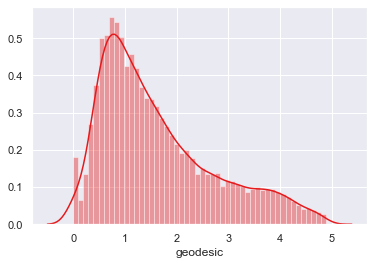

In [133]:
sns.distplot(train['geodesic'],bins=50)
# plt.savefig('distplot.png')

((array([-3.92007182, -3.70085568, -3.58076887, ...,  3.58076887,
          3.70085568,  3.92007182]),
  array([0.        , 0.        , 0.        , ..., 4.88300333, 4.88468361,
         4.88875044])),
 (1.06180023495338, 1.627580084949197, 0.9563204186016424))

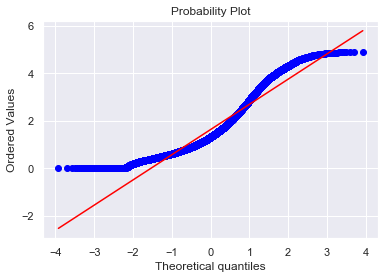

In [134]:
plt.figure()
stats.probplot(train['geodesic'], dist='norm', fit=True,plot=plt)
# plt.savefig('qq prob plot.png')

In [135]:
#Normalization
train['geodesic'] = (train['geodesic'] - min(train['geodesic']))/(max(train['geodesic']) - min(train['geodesic']))
test['geodesic'] = (test['geodesic'] - min(test['geodesic']))/(max(test['geodesic']) - min(test['geodesic']))

In [136]:
train['geodesic'].var()

0.051558897343726276

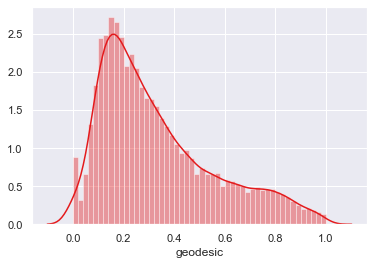

In [137]:
sns.distplot(train['geodesic'],bins=50)
plt.savefig('distplot.png')

((array([-3.92007182, -3.70085568, -3.58076887, ...,  3.58076887,
          3.70085568,  3.92007182]),
  array([0.        , 0.        , 0.        , ..., 0.99882442, 0.99916812,
         1.        ])),
 (0.2171925622554926, 0.33292353616935233, 0.9563204186016425))

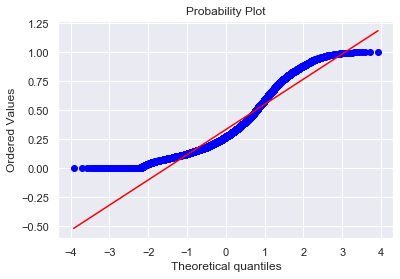

In [138]:
plt.figure()
stats.probplot(train['geodesic'], dist='norm', fit=True,plot=plt)
# plt.savefig('qq prob plot.png')

In [139]:
train.columns

Index(['fare_amount', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_spring', 'season_summer', 'season_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [140]:
train=train.drop(['passenger_count_2'],axis=1)
test=test.drop(['passenger_count_2'],axis=1)

In [141]:
train.columns

Index(['fare_amount', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'season_spring',
       'season_summer', 'season_winter', 'week_weekend', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'geodesic'],
      dtype='object')

## Splitting train into train and validation subsets
- X_train y_train--are train subset
- X_test y_test--are validation subset

In [142]:
X = train.drop('fare_amount',axis=1).values
y = train['fare_amount'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
print(train.shape, X_train.shape, X_test.shape,y_train.shape,y_test.shape)

(15660, 20) (11745, 19) (3915, 19) (11745,) (3915,)


In [143]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X_train)
    scores(y_train,y_pred)
    print('RMSLE:',rmsle(y_train,y_pred))
    print()
    print('<<<------------------- Test Data Score --------------------->')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(X_test)
    scores(y_test,y_pred)
    print('RMSLE:',rmsle(y_test,y_pred))

## Multiple Linear Regression

In [144]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'copy_X':[True, False],
          'fit_intercept':[True,False]}
# Instantiate a Decision reg classifier: reg
reg = LinearRegression()

# Instantiate the gridSearchCV object: reg_cv
reg_cv = GridSearchCV(reg, param_dist, cv=5,scoring='r2')

# Fit it to the data
reg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision reg Parameters: {}".format(reg_cv.best_params_))
print("Best score is {}".format(reg_cv.best_score_))

Tuned Decision reg Parameters: {'copy_X': True, 'fit_intercept': True}
Best score is 0.7354635192190567


R^2: 0.7419452241961555
Root Mean Squared Error: 2.3002420242265904
<<<------------------- Training Data Score --------------------->

r square   0.7343038486646856
Adjusted r square:0.7338732962659332
MAPE:18.736942495848997
MSE: 5.284481967778605
RMSE: 2.298800114794369
RMSLE: 0.216604357710992

<<<------------------- Test Data Score --------------------->

r square   0.7419452241961555
Adjusted r square:0.7406864204117465
MAPE:18.962996022136984
MSE: 5.291113370018041
RMSE: 2.3002420242265904
RMSLE: 0.21549985346796136
[ 1.54315806e-01  2.24592306e-01  2.37785373e-01  2.18257530e-01
 -4.37104209e-01 -4.40131450e-01 -4.70078285e-01 -2.04192062e-01
 -4.01234682e-01 -4.55112890e-01 -6.75183037e-01 -7.89462469e-01
 -7.98897397e-02 -1.38003960e-02  4.33441511e-01  1.28797506e+00
  1.50682737e+00  1.74253369e+00  1.67270577e+01]


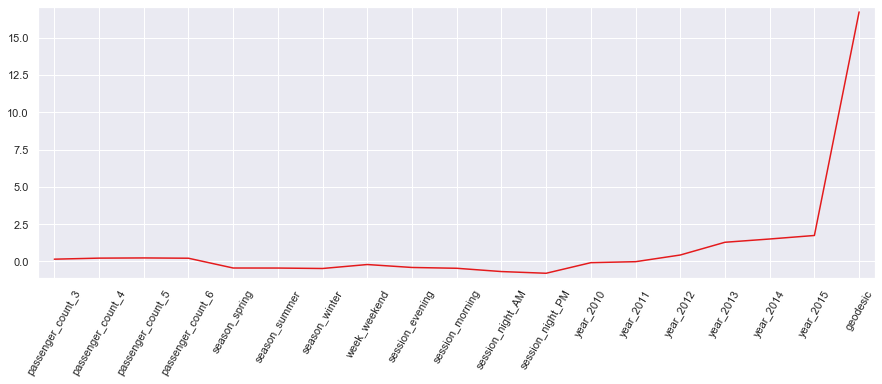

In [145]:
# Create the regressor: reg_all
reg_all = LinearRegression(copy_X= True, fit_intercept=True)

# Fit the regressor to the training data
reg_all.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
test_scores(reg_all)

# Compute and print the coefficients
reg_coef = reg_all.coef_
print(reg_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(test.columns)), reg_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('linear coefficients')
plt.show()

In [146]:
from sklearn.model_selection import cross_val_score
# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-5.31000604 -5.33675856 -5.10744856 -5.30305702 -5.42859022]
Average 5-Fold CV Score: -5.2971720791274155


## Ridge Regression

In [147]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision ridge classifier: ridge
ridge = Ridge()

# Instantiate the gridSearchCV object: ridge_cv
ridge_cv = GridSearchCV(ridge, param_dist, cv=5,scoring='r2')

# Fit it to the data
ridge_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision ridge Parameters: {}".format(ridge_cv.best_params_))
print("Best score is {}".format(ridge_cv.best_score_))

Tuned Decision ridge Parameters: {'alpha': 0.0005428675439323859, 'max_iter': 500, 'normalize': True}
Best score is 0.7354637543642079


[ 1.54161367e-01  2.24524076e-01  2.37424725e-01  2.18631885e-01
 -4.36140860e-01 -4.39254230e-01 -4.69243917e-01 -2.03879665e-01
 -4.00091599e-01 -4.53955304e-01 -6.73078300e-01 -7.87774559e-01
 -8.17278852e-02 -1.56004768e-02  4.31389103e-01  1.28557612e+00
  1.50424299e+00  1.73950747e+00  1.67176063e+01]


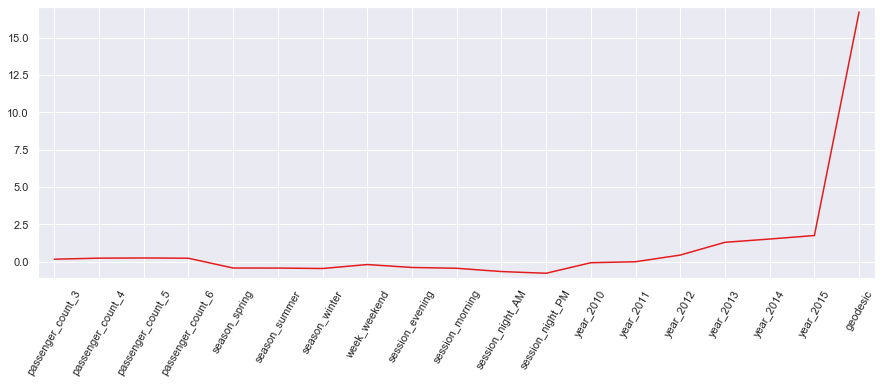

<<<------------------- Training Data Score --------------------->

r square   0.7343035716729962
Adjusted r square:0.7338730188253875
MAPE:18.74239262832452
MSE: 5.284487476919707
RMSE: 2.2988013130585485
RMSLE: 0.21659803884237225

<<<------------------- Test Data Score --------------------->

r square   0.741947502715943
Adjusted r square:0.7406887100462647
MAPE:18.968860392252317
MSE: 5.291066651616982
RMSE: 2.3002318690986314
RMSLE: 0.21549633941328936


In [148]:
# Instantiate a ridge regressor: ridge
ridge = Ridge(alpha=0.0005428675439323859, normalize=True,max_iter = 500)

# Fit the regressor to the data
ridge.fit(X_train,y_train)

# Compute and print the coefficients
ridge_coef = ridge.coef_
print(ridge_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(test.columns)), ridge_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
# plt.savefig('ridge coefficients')
plt.show()
test_scores(ridge)

lasso can be used feature selection

## Lasso Regression

In [149]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision lasso classifier: lasso
lasso = Lasso()

# Instantiate the gridSearchCV object: lasso_cv
lasso_cv = GridSearchCV(lasso, param_dist, cv=5,scoring='r2')

# Fit it to the data
lasso_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision lasso Parameters: {}".format(lasso_cv.best_params_))
print("Best score is {}".format(lasso_cv.best_score_))

Tuned Decision lasso Parameters: {'alpha': 0.00021209508879201905, 'max_iter': 500, 'normalize': False}
Best score is 0.73546427514537


[ 0.11458721  0.10614226  0.12840196  0.0970443  -0.3752226  -0.39314893
 -0.42775038 -0.18824363 -0.35500483 -0.45186563 -0.67320664 -0.7489739
 -0.04730828 -0.02357537  0.4703557   1.32109229  1.51204606  1.78037818
 16.71624519]


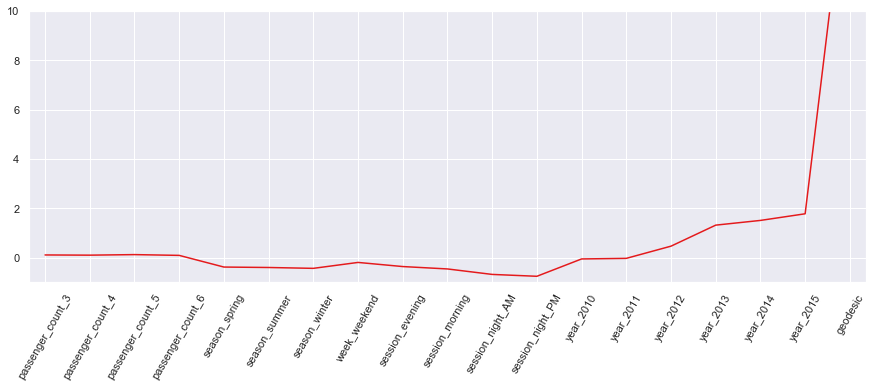

<<<------------------- Training Data Score --------------------->

r square   0.7341717777619992
Adjusted r square:0.7337410113464322
MAPE:18.757742098641508
MSE: 5.287108751419268
RMSE: 2.299371381795309
RMSLE: 0.21658114253588512

<<<------------------- Test Data Score --------------------->

r square   0.7427902220441789
Adjusted r square:0.741535540200492
MAPE:18.957565348725222
MSE: 5.273787670862172
RMSE: 2.2964728761433633
RMSLE: 0.21511951201708743


In [150]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.00021209508879201905, normalize=False,max_iter = 500)

# Fit the regressor to the data
lasso.fit(X,y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.ylim(-1,10)
plt.plot(range(len(test.columns)), lasso_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('lasso coefficients')
plt.show()
test_scores(lasso)

## Decision Tree Regression

In [151]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15660 entries, 0 to 15660
Data columns (total 20 columns):
fare_amount          15660 non-null float64
passenger_count_3    15660 non-null category
passenger_count_4    15660 non-null category
passenger_count_5    15660 non-null category
passenger_count_6    15660 non-null category
season_spring        15660 non-null category
season_summer        15660 non-null category
season_winter        15660 non-null category
week_weekend         15660 non-null category
session_evening      15660 non-null category
session_morning      15660 non-null category
session_night_AM     15660 non-null category
session_night_PM     15660 non-null category
year_2010            15660 non-null category
year_2011            15660 non-null category
year_2012            15660 non-null category
year_2013            15660 non-null category
year_2014            15660 non-null category
year_2015            15660 non-null category
geodesic             15660 non-null f

In [152]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the gridSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 6, 'min_samples_split': 4}
Best score is 0.7308995732854584


[2.84444261e-04 0.00000000e+00 0.00000000e+00 6.62482083e-04
 1.61062372e-04 0.00000000e+00 7.12401788e-04 1.20753457e-03
 3.70483099e-04 0.00000000e+00 0.00000000e+00 1.43606742e-04
 6.34699189e-04 0.00000000e+00 0.00000000e+00 1.12205718e-02
 1.19156808e-02 1.10211120e-02 9.61665921e-01]


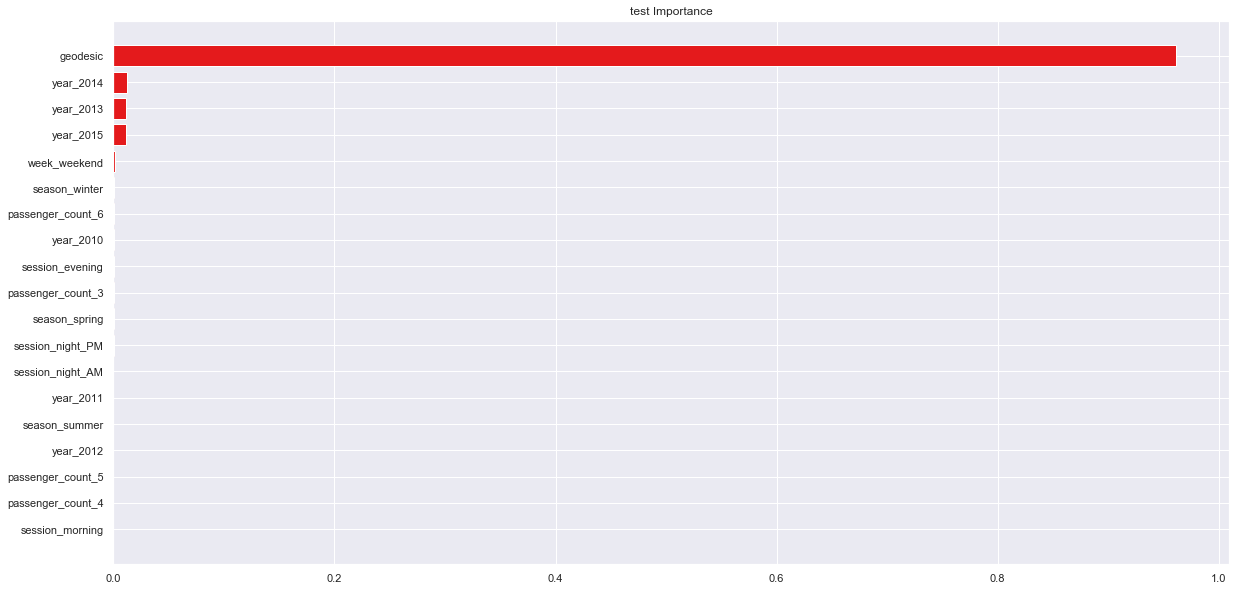

<<<------------------- Training Data Score --------------------->

r square   0.7471531379429529
Adjusted r square:0.7467434074202166
MAPE:18.547092626866394
MSE: 5.028919976577308
RMSE: 2.2425253569530286
RMSLE: 0.2087118879388544

<<<------------------- Test Data Score --------------------->

r square   0.7408782468914072
Adjusted r square:0.739614238339658
MAPE:19.07221916320597
MSE: 5.312990500038494
RMSE: 2.3049925162651816
RMSLE: 0.21233909238552046


In [153]:
# Instantiate a tree regressor: tree
tree = DecisionTreeRegressor(max_depth= 6, min_samples_split=2)

# Fit the regressor to the data
tree.fit(X_train,y_train)

# Compute and print the coefficients
tree_features = tree.feature_importances_
print(tree_features)

# Sort test importances in descending order
indices = np.argsort(tree_features)[::1]

# Rearrange test names so they match the sorted test importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("test Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),tree_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig('tree test importance')
plt.show()
# Make predictions and cal error
test_scores(tree)

## Random Forest Regression

In [154]:
# Create the random grid
random_grid = {'n_estimators': range(100,500,100),
               'max_depth': range(5,20,1),
               'min_samples_leaf':range(2,5,1),
              'max_features':['auto','sqrt','log2'],
              'bootstrap': [True, False],
              'min_samples_split': range(2,5,1)}
# Instantiate a Decision Forest classifier: Forest
Forest = RandomForestRegressor()

# Instantiate the gridSearchCV object: Forest_cv
Forest_cv = RandomizedSearchCV(Forest, random_grid, cv=5)

# Fit it to the data
Forest_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(Forest_cv.best_params_))
print("Best score is {}".format(Forest_cv.best_score_))

Tuned Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
Best score is 0.7432318635648989


[8.93579906e-04 5.42805364e-04 6.50918350e-04 4.87442379e-04
 2.71331768e-03 2.66459072e-03 2.45677445e-03 3.11627842e-03
 2.45417241e-03 2.40374013e-03 2.16086959e-03 4.09233036e-03
 2.60037646e-03 9.54588466e-04 1.76352709e-03 1.07705251e-02
 1.22945403e-02 9.63332726e-03 9.37346296e-01]


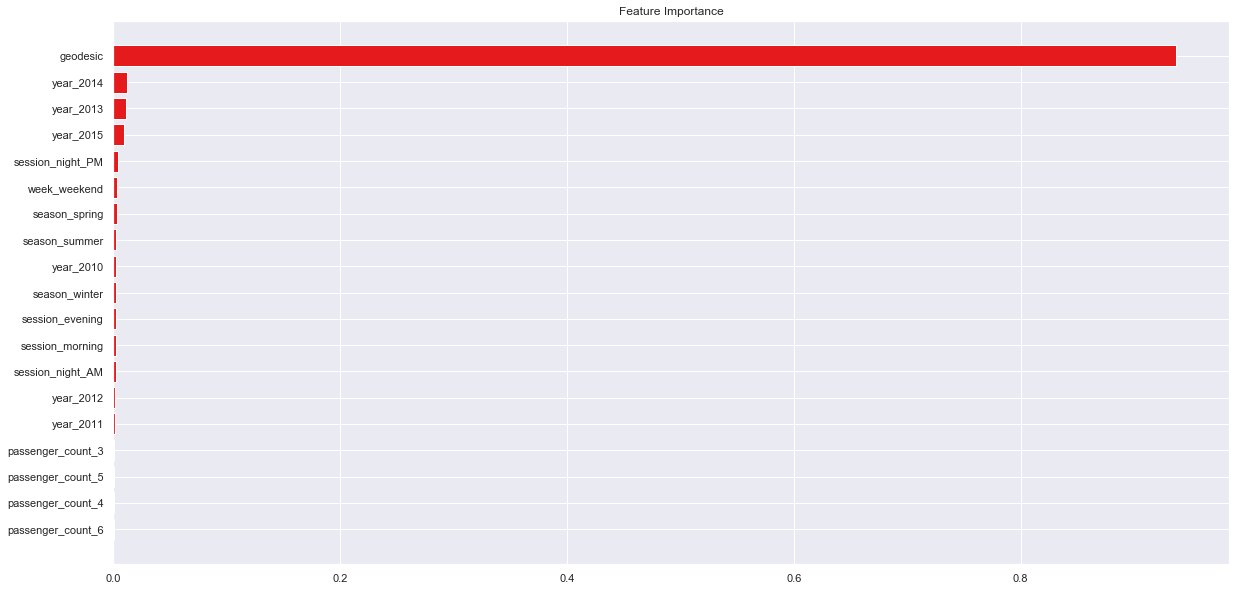

<<<------------------- Training Data Score --------------------->

r square   0.7890045168785423
Adjusted r square:0.7886626052214585
MAPE:16.95869214661158
MSE: 4.196529833926429
RMSE: 2.048543344409981
RMSLE: 0.19155872341944974

<<<------------------- Test Data Score --------------------->

r square   0.7543469239198453
Adjusted r square:0.7531486162316494
MAPE:18.568377919393516
MSE: 5.036830925468973
RMSE: 2.2442885120832776
RMSLE: 0.20702598215245438


In [155]:
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor(n_estimators=100, min_samples_split= 2, min_samples_leaf=4, max_features='auto', max_depth=9, bootstrap=True)

# Fit the regressor to the data
Forest.fit(X_train,y_train)

# Compute and print the coefficients
Forest_features = Forest.feature_importances_
print(Forest_features)

# Sort feature importances in descending order
indices = np.argsort(Forest_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),Forest_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig('Random forest feature importance')
plt.show()# Make predictions
test_scores(Forest)

In [156]:
from sklearn.model_selection import cross_val_score
# Create a random forest regression object: Forest
Forest = RandomForestRegressor(n_estimators=400, min_samples_split= 2, min_samples_leaf=4, max_features='auto', max_depth=12, bootstrap=True)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(Forest,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-5.19025513 -5.18817521 -5.1234359  -5.15062831 -5.13348252]
Average 5-Fold CV Score: -5.157195414356016


## Improving accuracy using XGBOOST
- Improve Accuracy a) Algorithm Tuning b) Ensembles

In [157]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [158]:
dtrain,dtest,data_dmatrix

(<xgboost.core.DMatrix at 0x29557151ac8>,
 <xgboost.core.DMatrix at 0x29557151a20>)

In [159]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

[15:37:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,9.178558,0.018805,9.178230,0.082367
1,8.454234,0.079829,8.451906,0.033413
2,7.846118,0.083607,7.843625,0.031579
3,7.242007,0.100657,7.240654,0.068648
4,6.777473,0.106058,6.776374,0.073280


In [160]:
# the final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

49    2.585023
Name: test-rmse-mean, dtype: float64


In [161]:
Xgb = XGBRegressor()
Xgb.fit(X_train,y_train)
# pred_xgb = model_xgb.predict(X_test)
test_scores(Xgb)

[15:37:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<<<------------------- Training Data Score --------------------->

r square   0.7608853411883156
Adjusted r square:0.760497863276382
MAPE:17.83934902657697
MSE: 4.7557975392996665
RMSE: 2.1807791129088856
RMSLE: 0.2012889741509688

<<<------------------- Test Data Score --------------------->

r square   0.7598553804648028
Adjusted r square:0.7586839432963385
MAPE:18.226158089842883
MSE: 4.923886423735188
RMSE: 2.2189831959109534
RMSLE: 0.20444191558083114


In [162]:
# Create the random grid
para = {'n_estimators': range(100,500,100),
               'max_depth': range(3,10,1),
        'reg_alpha':np.logspace(-4, 0, 50),
        'subsample': np.arange(0.1,1,0.2),
        'colsample_bytree': np.arange(0.1,1,0.2),
        'colsample_bylevel': np.arange(0.1,1,0.2),
        'colsample_bynode': np.arange(0.1,1,0.2),
       'learning_rate': np.arange(.05, 1, .05)}
# Instantiate a Decision Forest classifier: Forest
Xgb = XGBRegressor()

# Instantiate the gridSearchCV object: Forest_cv
xgb_cv = RandomizedSearchCV(Xgb, para, cv=5)

# Fit it to the data
xgb_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Xgboost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))


[15:37:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:43] WARNI

[15:39:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.01516918 0.02923244 0.01735285 0.02016297 0.02591611 0.02109326
 0.02112372 0.02365389 0.02106285 0.02487816 0.03186403 0.02625964
 0.04194061 0.02615565 0.02046719 0.05040023 0.04284481 0.04546393
 0.4949585 ]


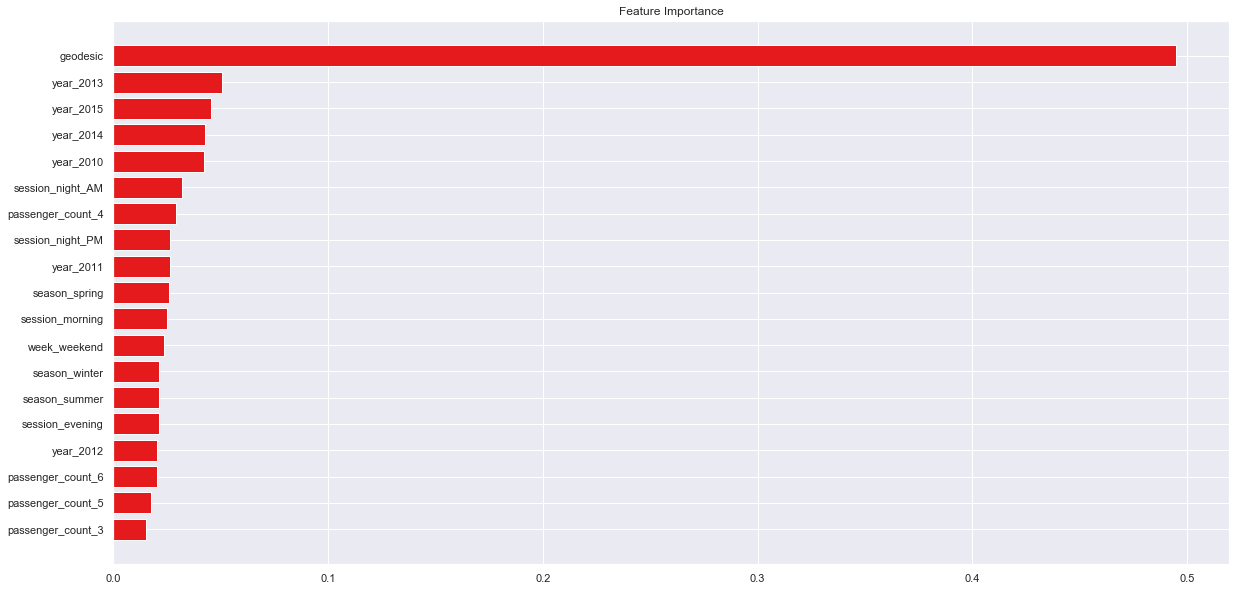

<<<------------------- Training Data Score --------------------->

r square   0.7543290924064688
Adjusted r square:0.7539309902960827
MAPE:18.07903934192177
MSE: 4.8861960350619
RMSE: 2.2104741652102384
RMSLE: 0.2043483271583934

<<<------------------- Test Data Score --------------------->

r square   0.7567651207545583
Adjusted r square:0.755578609148483
MAPE:18.370899009230303
MSE: 4.987248608832402
RMSE: 2.2332148595315235
RMSLE: 0.20598572721276143


In [163]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, 
                   colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X_train,y_train)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig(' xgb feature importance')
plt.show()# Make predictions
test_scores(Xgb)

## Finalize model
- Create standalone model on entire training dataset
- Save model for later use

In [164]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def score(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_)))
    print('RMSLE:',rmsle(y_test,y_pred))
def scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X)
    score(y,y_pred)
    print('RMSLE:',rmsle(y,y_pred))   

In [165]:
test.columns

Index(['passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_spring', 'season_summer', 'season_winter',
       'week_weekend', 'session_evening', 'session_morning',
       'session_night_AM', 'session_night_PM', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [166]:
train.columns

Index(['fare_amount', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'season_spring',
       'season_summer', 'season_winter', 'week_weekend', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'geodesic'],
      dtype='object')

In [167]:
train.shape

(15660, 20)

In [168]:
test.shape

(9914, 19)

In [169]:
a=pd.read_csv('test.csv')

In [170]:
test_pickup_datetime=a['pickup_datetime']

[15:39:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.01180044 0.01702503 0.01385899 0.01747716 0.01772899 0.0177025
 0.01865518 0.02171154 0.01478301 0.01813335 0.02376898 0.0213527
 0.03959981 0.02547468 0.01891761 0.04394775 0.05951867 0.03731965
 0.56122404]


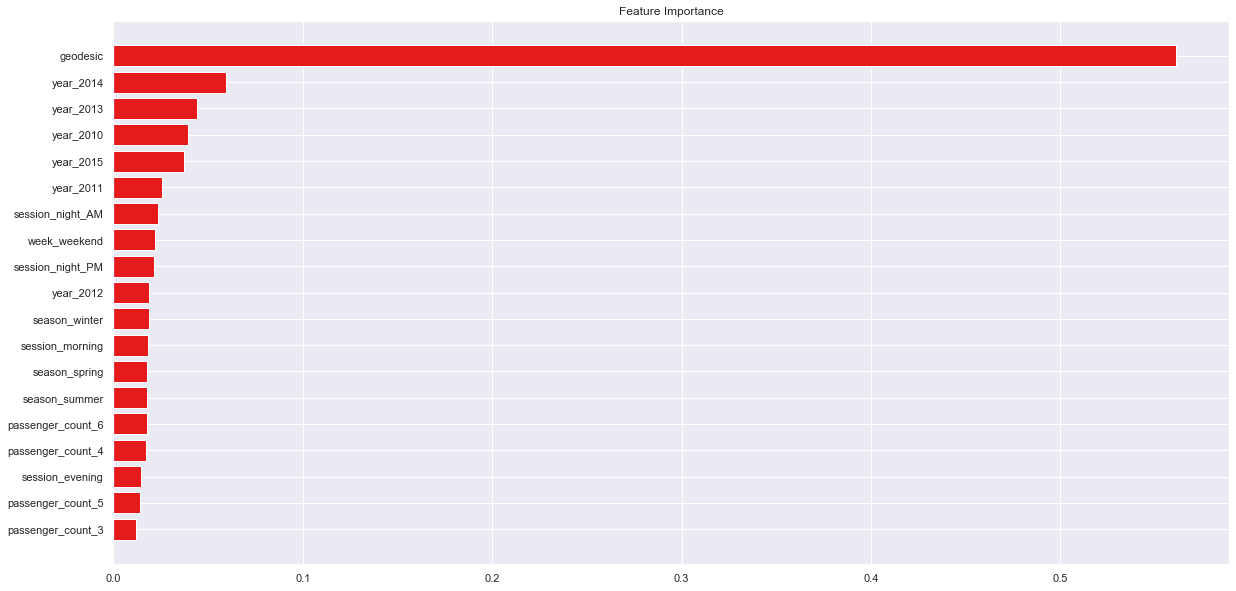

<<<------------------- Training Data Score --------------------->

r square   0.7556219994167432
Adjusted r square:0.7553251207715334
MAPE:18.231745927702377
MSE: 4.898063257414623
RMSE: 2.213156853323917
RMSLE: 0.21549985346796136
RMSLE: 0.20466777322129343


In [171]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, 
                   colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X,y)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig(' xgb1 feature importance')
plt.show()
scores(Xgb)

# Predictions
pred = Xgb.predict(test.values)
pred_results_wrt_date = pd.DataFrame({"pickup_datetime":test_pickup_datetime,"fare_amount" : pred})
pred_results_wrt_date.to_csv("predictions_xgboost.csv",index=False)

In [172]:
pred_results_wrt_date

,pickup_datetime,fare_amount
0,2015-01-27 13:08:24 UTC,6.341049
1,2015-01-27 13:08:24 UTC,6.341049
2,2011-10-08 11:53:44 UTC,4.584339
3,2012-12-01 21:12:12 UTC,5.428340
4,2012-12-01 21:12:12 UTC,4.627237
...,...,...
9909,2015-05-10 12:37:51 UTC,6.405533
9910,2015-01-12 17:05:51 UTC,5.997406
9911,2015-04-19 20:44:15 UTC,8.425615
9912,2015-01-31 01:05:19 UTC,6.169562


In [173]:
# Save the model as a pickle in a file 
joblib.dump(Xgb, 'cab_fare_xgboost_model.pkl') 
  
# # Load the model from the file 
# Xgb_from_joblib = joblib.load('cab_fare_xgboost_model.pkl')  

['cab_fare_xgboost_model.pkl']